<a href="https://colab.research.google.com/github/Ohmyprogram/Delivery-Robot-TextMining/blob/main/%EA%B0%90%EC%84%B1%EC%9D%BC%EA%B8%B0%EB%B6%84%EC%84%9D_FinalCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 그래프 한글표현

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,883 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

# 1. 코랩 환경 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 디렉토리 변경
%cd drive/MyDrive/혁신기술텍스트마이닝

/content/drive/MyDrive/혁신기술텍스트마이닝


In [ ]:
# 현재 디렉토리 경로 확인
!pwd

/content/drive/MyDrive/혁신기술텍스트마이닝


In [ ]:
!pip install git+https://github.com/ssut/py-hanspell.git
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-elsz0pw2
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-elsz0pw2
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=1dacea48bb3508856143677277339f98401173335fae3356b6b481ad6540e4d3
  Stored in directory: /tmp/pip-ephem-wheel-cache-zy5dwvga/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 데이터 전처리

## 필요한 라이브러리

In [ ]:
!pip install PyKomoran

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.3 MB/s 
     |████████████████████████████████| 198 kB 55.9 MB/s 


In [ ]:
import io
import pandas as pd
import csv
import re
from hanspell import spell_checker
from tqdm import tqdm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from PyKomoran import *
from collections import defaultdict
import itertools
from wordcloud import WordCloud

## 엑셀파일 불러오기

In [ ]:
file_name = "/content/drive/MyDrive/혁신기술텍스트마이닝/감성일기RAWDATA(혁신기술리빙랩_스타트업파크)_ver0.2.xlsx"
team = int(input('팀을 입력하세요: '))
df_diary = pd.read_excel(file_name, sheet_name = team-1)
df_diary.head()

팀을 입력하세요: 1


,ID,이름,팀,구분,물품주문,물품배송,물품수령,물품확인
0,1.0,김원미,1.0,1.0,"주문은 일반 배달 앱 주문과 다르지 않았으나, 주소를 입력하는 것에서 오류(ex. ...",배달 로봇 실증은 배달원과 비대면으로 이루어지는 것이 원칙이라고 생각했다.,대면으로 받았음에도 로봇을 이용해보고 싶어 배달원에게 로봇에라도 넣어 달라고 했는데...,첫번째 실증에서는 만족스러운점이 없었다.​
1,2.0,김원미,1.0,1.0,그리고 배달 상점 리스트에 적혀 있는 업체들이 “리빙랩＂에 대한 인지가 있는 지도 ...,(그래서 공지사항으로 대면결제가 불가능하다고 했다.),스타트업파크 로비에서 운영을 담당하고 계시는 분에게 물어봤는데 인증번호가 있어야 한...,로봇을 이용해 볼 수 없었기 때문이다.​
2,3.0,김원미,1.0,1.0,NaN,"하지만 배달원은 인천스타트업파크의 출입문 부터 찾지 못하여 연락이 왔고, 결국 로봇...",\n배달상점리스트에 있는 업체 및 배달원들의 “리빙랩“ 사업에 대한 인식이 꼭 필요...,그래도 로비에서 안내해주시는 분이 문제점을 바로 찾아 알려주셔서 괜찮았다.​
3,4.0,김원미,1.0,1.0,NaN,심지어 외국인배달원이라 의사소통 조차 되지 못했다.​,시민단만 참여한다고 해서 이루어지는 실증이 아니라 공급해주는 업체에서 같이 이 실증...,앞으로 개선점을 해결하기 위해 많은 노력이 필요할 듯 싶다.​
4,5.0,김원미,1.0,2.0,지난 번 실증에서 로봇을 전혀 이용하지 못한 경험을 바탕으로 주문할 때 “리빙랩 참...,배달 도착이 언제 되려나 하고 기다리고 있었는데 리빙랩 안내하시는 분이 사무실로 찾...,전화를 못 받은(당연하다. 왜냐하면 애초에 전화가 오지 않았기 때문) 문제를 내 탓...,처음으로 로봇을 통해 받아 보았지만 정상적으로 이루어진 것이 아니라서 아쉬웠다.​


## 이모지처리 및 맞춤법 검사

In [ ]:
# 텍스트 전처리
def cleanText(text):
  specialChar = '[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》❤♥♡ㅏㅑㅓㅑㅗㅛㅜㅠㅢㅡㅣㄱㄴㄷㄹㅁㅂㅅㅇㅈㅊㅋㅌㅍㅎㄲㄸㅆㅉㅃ]'
  text = ''.join(c for c in text if c not in specialChar)
  only_BMP_pattern = re.compile("["
        u"\U00010000-\U0010FFFF"  #BMP characters 이외 (이모지 제거)
                           "]+", flags=re.UNICODE)
  return only_BMP_pattern.sub(r'', text)

# 맞춤법 검사
def spell_check(comments):
  for k in tqdm(range(len(comments))):
    comments[k] = cleanText(comments[k])
    spelled_sent = spell_checker.check(comments[k])
    checked_sent = spelled_sent.checked
    comments[k] = checked_sent
  print("맞춤법 검사 완료")

## 단문파일생성

In [ ]:
# ## 물품주문/배송/수령/확인-단문 매트릭스 생성
# comments = df_diary.loc[:,['물품주문', '물품배송', '물품수령', '물품확인']]
# id = df_diary.loc[:,['ID']]

# for name in list(comments.columns) :
#   df_comments = pd.DataFrame({'ID':[]})
#   co = list(comments[name])
#   sentences = []
#   num = []
#   n = 0
#   for c in range(len(co)):
#     sen = co[c].split('.')
#     sen.pop()
#     sentences += sen
#     num += [n] * len(sen)
#     n += 1
#     print(sentences)
#     print(num)

#   df_comments[name] = sentences
#   df_comments['ID'] = num

#   # csv 파일로 저장
#   spell_check(df_comments[name])
#   df_comments.to_csv(name+"_spell_checked.csv")

# 단문처리 된 데이터 전처리

In [ ]:
# senario1 = df_diary.loc[:,['물품주문']]
# senario2 = df_diary.loc[:,['물품배송']]
# senario3 = df_diary.loc[:,['물품수령']]
# senario4 = df_diary.loc[:,['물품확인']]

# senario1 = senario1.dropna()
# senario1 = senario1.reset_index()
# spell_check(senario1['물품주문'])
# senario1.to_csv("물품주문_spell_checked.csv")

# senario2 = senario2.dropna()
# senario2 = senario2.reset_index()
# spell_check(senario2['물품배송'])
# senario2.to_csv("물품배송_spell_checked.csv")

# senario3 = senario3.dropna()
# senario3 = senario3.reset_index()
# spell_check(senario3['물품수령'])
# senario3.to_csv("물품수령_spell_checked.csv")

# senario4 = senario4.dropna()
# senario4 = senario4.reset_index()
# spell_check(senario4['물품확인'])
# senario4.to_csv("물품확인_spell_checked.csv")

  0%|          | 0/56 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
100%|██████████| 56/56 [00:11<00:00,  4.92it/s]


맞춤법 검사 완료


100%|██████████| 55/55 [00:10<00:00,  5.20it/s]


맞춤법 검사 완료


100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


맞춤법 검사 완료


100%|██████████| 40/40 [00:07<00:00,  5.25it/s]

맞춤법 검사 완료


전처리한 데이터로 감정태깅

In [ ]:
# 감정태깅 끝난 전처리 데이터를 넣어서, 토큰화한 내용 담은 열과, 토큰화된 단어 담는 열을 포함하는 데이터 프레임 반환하는 함수

def komoran_comments():
  team = int(input("팀을 입력하세요 :"))
  senario = input("시나리오 단계를 입력하세요 : ")
  df_comments1 = pd.read_excel("/content/drive/MyDrive/혁신기술텍스트마이닝/"+str(team)+"팀감성일기/"+senario+"_spell_checked.xlsx")
  df_comments1.drop(['Unnamed: 0'], axis = 1, inplace = True)
  df_comments1_emo = df_comments1

  # df_comments1_emo = df_comments1[df_comments1['Unnamed: 3'] != 0]      # 긍정/부정 문장들만 추출(중성 문장들은 다 제외)
  df_comments1_emo = df_comments1[df_comments1['EMO'] != 0]
  df_comments1_emo = df_comments1_emo.reset_index(drop=True)  # 인덱스 리셋

  komoran = Komoran("EXP")
# komoran.set_user_dic("user_dictionary.txt")  #사용자 정의 사전 등록

  df_comments1_emo['tokens'] = df_comments1_emo[senario].map(lambda s: komoran.get_plain_text(s).split('\s'))

  tag_list = ['NNG','NNP','VA','XR']
  df_comments1_emo['specific_tokens'] = df_comments1_emo[senario].map(lambda s: komoran.get_morphes_by_tags(s, tag_list= tag_list))

  return df_comments1_emo

<>:17: DeprecationWarning: invalid escape sequence \s
<>:17: DeprecationWarning: invalid escape sequence \s
<>:17: DeprecationWarning: invalid escape sequence \s
<ipython-input-418-16a31fd38325>:17: DeprecationWarning: invalid escape sequence \s
  df_comments1_emo['tokens'] = df_comments1_emo[senario].map(lambda s: komoran.get_plain_text(s).split('\s'))


In [ ]:
df1 = komoran_comments()
df1.head()

팀을 입력하세요 :1
시나리오 단계를 입력하세요 : 물품확인


,index,물품확인,EMO,tokens,specific_tokens
0,0.0,첫 번째 실증에서는 만족스러운 점이 없었다​,-1.0,[첫/MM 번째/NNB 실증/NNG 에서/JKB 는/JX 만족스럽/VA ㄴ/ETM ...,"[실증, 만족스럽, 점, 없]"
1,1.0,로봇을 이용해 볼 수 없었기 때문이다​,-1.0,[로봇/NNG 을/JKO 이용/NNG 하/XSV 아/EC 보/VV ㄹ/ETM 수/N...,"[로봇, 이용, 없]"
2,2.0,그래도 로비에서 안내해주시는 분이 문제점을 바로 찾아 알려주셔서 괜찮았다​,1.0,[그래도/MAJ 로비/NNG 에서/JKB 안내/NNG 해주시/NNP 는/JX 분/N...,"[로비, 안내, 해주시, 문제점, 괜찮]"
3,3.0,앞으로 개선점을 해결하기 위해 많은 노력이 필요할 듯싶다​,-1.0,[앞/NNG 으로/JKB 개선/NNG 점/NNG 을/JKO 해결/NNG 하/XSV ...,"[앞, 개선, 점, 해결, 많, 노력, 필요]"
4,4.0,처음으로 로봇을 통해 받아 보았지만 정상적으로 이루어진 것이 아니라서 아쉬웠다​,-1.0,[처음/NNG 으로/JKB 로봇/NNG 을/JKO 통하/VV 아/EC 받/VV 아/...,"[처음, 로봇, 정상, 아쉽]"


In [ ]:
# df1 : 긍정+부정 문장
df1_positive = df1[df1['EMO'] == 1]    # 긍정문장
df1_negative = df1[df1['EMO'] == -1]   # 부정문장

# df1_positive = df1[df1['Unnamed: 3'] == 1]    # 긍정문장
# df1_negative = df1[df1['Unnamed: 3'] == -1]   # 부정문장

In [ ]:
# word, count 로 구성된 단어 빈도수 데이터 프레임 리턴하는 함수
def Word_DF(DF, tag_ls):
  tokens = list(itertools.chain.from_iterable(DF['specific_tokens']))
  word_df = pd.DataFrame.from_dict(Counter(tokens),orient='index').reset_index()
  word_df = word_df.rename(columns = {'index':'WORD', 0 : 'count'})
  word_df = word_df.sort_values('count', ascending = False).reset_index(drop = True)

  return word_df

# 감정문장에서 단어 빈도분석 및 시각화

## 감정 문장에서 단어 빈도분석

In [ ]:
# 긍정+부정 문장에서 명사, 형용사,어근 빈도수 출력
tag_list = ['NNG','NNP','VA','XR']
df_word = Word_DF(df1, tag_list)
df_word.head()

,WORD,count
0,배달,10
1,로봇,9
2,음식,7
3,사용,5
4,물품,5


In [ ]:
df_word.to_csv("4팀_물품확인_단어빈도.csv", encoding = 'cp949')

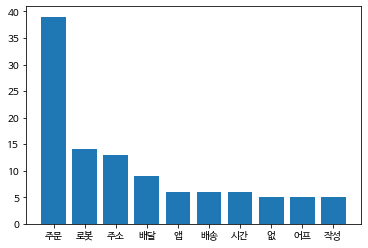

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

# 빈도수 바 그래프 그리기(상위 10개)
def showGraph(bargraph, num = 10):
     xtick = bargraph['WORD'][:num] # 단어
     ytick = bargraph['count'][:num] # 빈도수
     plt.figure()
    #  mycolors = ['#06c2ac', '#c79fef', '#ff796c', '#aaff32', '#0485d1', '#d648d7', '#a5a502', '#d8dcd6', '#5ca904', '#fffe7a' ]
     plt.bar(xtick, ytick)


showGraph(df_word)            # 명사, 형용사, 어근에 대해 빈도수 가장 많은 top 10 출력

plt.show()

## 감정 문장에서 감정단어 빈도분석

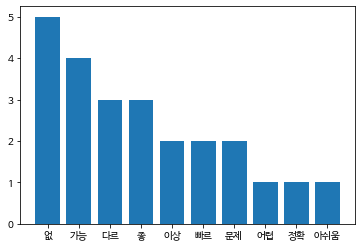

In [ ]:
import copy

# 단어들 중 감정 단어 빈도 출력 및 시각화
df_emo_dic = pd.read_excel("/content/drive/MyDrive/혁신기술텍스트마이닝/윤아/dic/emo_dic.xlsx")
emo_dic = df_emo_dic['WORD']
df_word_emo = copy.deepcopy(df_word)

for w in range(len(df_word['WORD'])):
  if df_word['WORD'][w] not in list(emo_dic):
    df_word_emo.loc[w, 'WORD'] = np.nan

df_word_emo = df_word_emo.dropna()
df_word_emo = df_word_emo.reset_index(drop = True)

showGraph(df_word_emo)      # 감성단어에서 가장 많은 top 10 출력

plt.show()

## 워드 클라우드

In [ ]:
# word_list 리턴하는 함수
def make_word_ls(spe_token):
  word_ls = []
  for t in spe_token:
    word_ls += t

  return word_ls

In [ ]:
# df_emo_dic = pd.read_excel("/content/drive/MyDrive/혁신기술텍스트마이닝/윤아/dic/emo_dic.xlsx")
# emo_dic = list(df_emo_dic['WORD'])

wl = make_word_ls(df1_positive['specific_tokens'])  # 모든 단어 있는 ver
# wl_notin_emo = [w for w in wl if w not in emo_dic and len(w) > 1]  #감정단어 제외 ver
# wl_in_emo = [w for w in wl if w in emo_dic]  #감정단어만 있는 ver

# 뺄 단어 빼기
wl = [x for x in wl if x not in ['로봇', '배송', '배달', '주문', '수령', '생각']]
wl = [x for x in wl if len(x) > 1]  # 길이가 1인 건 제외
for w in range(len(wl)):
  if wl[w] == '어프':
    wl[w] = '어플'

In [ ]:
from PIL import Image

def wordcloud_mk(word_ls):
  im = Image.open('circle.png') # 이미지 파일 읽어오기
  mask_arr = np.array(im) # 픽셀 값 배열 형태 변환

  font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
  wordcloud = WordCloud(
  font_path = font_path,
  width = 800,
  height = 800,
  colormap = 'Dark2',
  background_color="white",
  mask = mask_arr,
  prefer_horizontal = True
  )

  count = Counter(word_ls)
  wordcloud = wordcloud.generate_from_frequencies(count)
  array = wordcloud.to_array()

  plt.rc('font', family='NanumBarunGothic')
  fig = plt.figure(figsize=(10, 10))
  plt.imshow(array, interpolation="bilinear")

  plt.axis('off')

  plt.show()

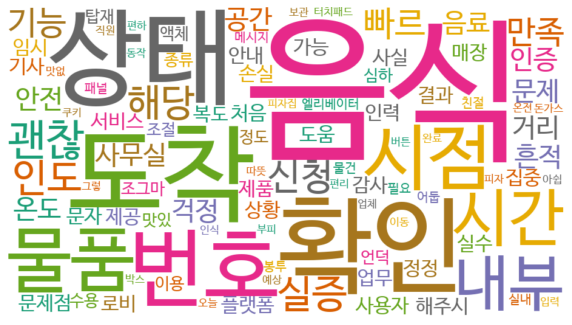

In [ ]:
wordcloud_mk(wl)

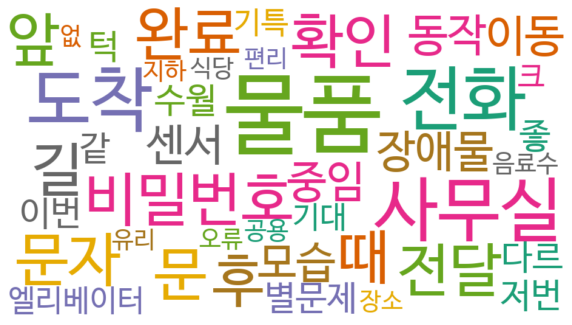

In [ ]:
wordcloud_mk(wl)

# 긍정/부정 문장에서 감정단어 제외한 워드클라우드

## 긍정문장

In [ ]:
# df1_positive = df1[df1['EMO'] == 1]    # 긍정문장
# df1_negative = df1[df1['EMO'] == -1]   # 부정문장

In [ ]:
# 긍정 문장에서 명사, 형용사,어근 빈도수 출력
# tag_list = ['NNG','NNP','VA','XR']
df_word = Word_DF(df1_positive, tag_list)
df_word.head()

In [ ]:
import copy

# 긍정 문장에서 단어들 중 감정 단어 빈도 출력 및 시각화
# df_emo_dic = pd.read_excel("/content/drive/MyDrive/혁신기술텍스트마이닝/윤아/dic/emo_dic.xlsx")
# emo_dic = df_emo_dic['WORD']
df_word_emo = copy.deepcopy(df_word)

for w in range(len(df_word['WORD'])):
  if df_word['WORD'][w] not in list(emo_dic):
    df_word_emo.loc[w, 'WORD'] = np.nan

df_word_emo = df_word_emo.dropna()
df_word_emo = df_word_emo.reset_index(drop = True)

showGraph(df_word_emo)      # 감성단어에서 가장 많은 top 10 출력

plt.show()

In [ ]:
# 긍정 문장에서 감정단어 제외한 워드클라우드 출력
# tag_list = ['NNG','NNP','VA','XR']
wl = make_word_ls(df1_positive['specific_tokens'])  # 모든 단어 있는 ver
wl_notin_emo = [w for w in wl if w not in emo_dic and len(w) > 1]  #감정단어 제외 ver
wl_in_emo = [w for w in wl if w in emo_dic]  #감정단어만 있는 ver

wordcloud_mk(wl_notin_emo)

## 부정문장

In [ ]:
# 부정 문장에서 명사, 형용사,어근 빈도수 출력
# tag_list = ['NNG','NNP','VA','XR']
df_word = Word_DF(df1_negative, tag_list)
df_word.head()

In [ ]:
import copy

# 부정 문장에서 단어들 중 감정 단어 빈도 출력 및 시각화
# df_emo_dic = pd.read_excel("/content/drive/MyDrive/혁신기술텍스트마이닝/윤아/dic/emo_dic.xlsx")
# emo_dic = df_emo_dic['WORD']
df_word_emo = copy.deepcopy(df_word)

for w in range(len(df_word['WORD'])):
  if df_word['WORD'][w] not in list(emo_dic):
    df_word_emo.loc[w, 'WORD'] = np.nan

df_word_emo = df_word_emo.dropna()
df_word_emo = df_word_emo.reset_index(drop = True)

showGraph(df_word_emo)      # 감성단어에서 가장 많은 top 10 출력

plt.show()

In [ ]:
# 부정 문장에서 감정단어 제외한 워드클라우드 출력
# tag_list = ['NNG','NNP','VA','XR']
wl = make_word_ls(df1_negative['specific_tokens'])  # 모든 단어 있는 ver
wl_notin_emo = [w for w in wl if w not in emo_dic and len(w) > 1]  #감정단어 제외 ver
wl_in_emo = [w for w in wl if w in emo_dic]  #감정단어만 있는 ver

wordcloud_mk(wl_notin_emo)

# LDA(토픽모델링)

In [ ]:
# !pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 50.6 MB/s 


In [ ]:
import konlpy
import re

# tokenization 함수를 만들어둠
def tokenize_korean_text(text):
    text = re.sub(r'[^,.?!\w\s]','', text)  ## ,.?!와 문자+숫자+_(\w)와 공백(\s)만 남김  # 앞에 r을 붙여주면 deprecation warning이 안뜸 (raw string으로 declare)

    okt = konlpy.tag.Okt()
    Okt_morphs = okt.pos(text)   # stem=True로 설정하면 동사원형으로 바꿔서 return

    words = []
    for word, pos in Okt_morphs:
        if pos == 'Adjective' or pos == 'Verb' or pos == 'Noun':  # 이 경우에는 형용사, 동사, 명사만 남김
            words.append(word)

    words_str = ' '.join(words)
    return words_str

In [ ]:
# 감정태깅 끝난 전처리 데이터를 넣어서, 토큰화한 내용 담은 열과, 토큰화된 단어 담는 열을 포함하는 데이터 프레임 반환하는 함수

def komoran_comments(senario):
  team = int(input("팀을 입력하세요 :"))
  df_comments1 = pd.read_excel("/content/drive/MyDrive/혁신기술텍스트마이닝/"+str(team)+"팀감성일기/"+senario+"_spell_checked.xlsx")
  df_comments1.drop(['Unnamed: 0'], axis = 1, inplace = True)
  df_comments1_emo = df_comments1

  df_comments1_emo = df_comments1[df_comments1['Unnamed: 3'] != 0]      # 긍정/부정 문장들만 추출(중성 문장들은 다 제외)
  # df_comments1_emo = df_comments1[df_comments1['EMO'] != 0]
  df_comments1_emo = df_comments1_emo.reset_index(drop=True)  # 인덱스 리셋

  komoran = Komoran("EXP")
# komoran.set_user_dic("user_dictionary.txt")  #사용자 정의 사전 등록

  df_comments1_emo['tokens'] = df_comments1_emo[senario].map(lambda s: komoran.get_plain_text(s).split('\s'))

  tag_list = ['NNG','NNP','VA','XR']
  df_comments1_emo['specific_tokens'] = df_comments1_emo[senario].map(lambda s: komoran.get_morphes_by_tags(s, tag_list= tag_list))

  return df_comments1_emo

<>:16: DeprecationWarning: invalid escape sequence \s
<>:16: DeprecationWarning: invalid escape sequence \s
<>:16: DeprecationWarning: invalid escape sequence \s
<ipython-input-427-5c864856fbd2>:16: DeprecationWarning: invalid escape sequence \s
  df_comments1_emo['tokens'] = df_comments1_emo[senario].map(lambda s: komoran.get_plain_text(s).split('\s'))


In [ ]:
senario = input("시나리오 단계를 입력하세요 :")
df1 = komoran_comments(senario)
df1.head()

시나리오 단계를 입력하세요 :물품주문
팀을 입력하세요 :1


,index,물품주문,Unnamed: 3,tokens,specific_tokens
0,0.0,주문은 일반 배달 앱 주문과 다르지 않았으나 주소를 입력하는 것에서 오류 ex 도로...,-1.0,[주문/NNG 은/JX 일반/NNG 배달/NNG 앱/NNG 주문/NNG 과/JC 다...,"[주문, 일반, 배달, 앱, 주문, 다르, 주소, 입력, 오류, 도로명, 주소, 지..."
1,1.0,그리고 배달 상점 리스트에 적혀 있는 업체들이 “리빙랩＂에 대한 인지가 있는 지도 ...,-1.0,[그리고/MAJ 배달/NNG 상점/NNG 리스트/NNG 에/JKB 적히/VV 어/E...,"[배달, 상점, 리스트, 업체, 리빙, 랩, 인지, 지도, 의문]"
2,41.0,어떤 방식으로 배달 주문이 되는지에 대해 첫 주문이라 그런지 아직은 헷갈렸다,-1.0,[어떤/MM 방식/NNG 으로/JKB 배달/NNG 주문/NNG 이/JKS 되/VV ...,"[방식, 배달, 주문, 주문, 그렇]"
3,42.0,내가 특정 장소로 가야 하는 것도 익숙지가 않았다,-1.0,[내/NP 가/JKS 특정/NNG 장소/NNG 로/JKB 가/VV 아야/EC 하/V...,"[특정, 장소, 익숙]"
4,43.0,또한 주문을 10개 이상할 수 없어 단체 주문을 하기는 힘들 것 같다​,-1.0,[또한/MAG 주문/NNG 을/JKO 10/SN 개/NNB 이상/NNG 하/XSV ...,"[주문, 이상, 없, 단체, 주문, 힘들, 같]"


In [ ]:
# df['Content']를 하나씩 tokenize해서 list로 저장
tokenized_list = []

for text in df1[senario]:
    tokenized_list.append(tokenize_korean_text(text))

print(len(tokenized_list))
print(tokenized_list[0])

26
주문 일반 배달 앱 주문 다르지 않았으나 주소 입력 하는 것 오류 도로명 주소 지번 주소 인식 함 등 자주 발생 하여 주소 정확하게 봐야 하는 문제점 있었다


In [ ]:
df = copy.deepcopy(df1)
drop_corpus = []

for index in range(len(tokenized_list)):
    corpus = tokenized_list[index]
    if len(set(corpus.split())) < 3:   # 같은 단어 1-2개만 반복되는 corpus도 지우기 위해 set()을 사용
        df.drop(index, axis='index', inplace=True)
        drop_corpus.append(corpus)

for corpus in drop_corpus:
    tokenized_list.remove(corpus)

df.reset_index(drop=True, inplace=True)

print(len(tokenized_list))
print(len(df))

26
26


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
#LDA 는 Count기반의 Vectorizer만 적용
count_vectorizer = CountVectorizer(ngram_range=(1,2))
    # 2개의 문서 미만으로 등장하는 단어는 제외, 전체의 10% 이상으로 자주 등장하는 단어는 제외
    # bigram도 포함

feat_vect = count_vectorizer.fit_transform(tokenized_list)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (26, 452)


In [ ]:
lda = LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_jobs=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0, n_components=2)  # 토픽 수는 2개로 설정
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=2)

In [ ]:
def display_topics(model, feature_names, num_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #', topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환.
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:num_top_words]

        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])
        print(feature_concat)

In [ ]:
# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vectorizer.get_feature_names()

# Topic별 가장 연관도가 높은 word를 3개만 추출
display_topics(lda, feature_names, 3)

Topic # 0
주문 주소 해당
Topic # 1
주문 배달 주소


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# !pip install pyLDAvis

In [ ]:
import pyLDAvis.sklearn  # sklearn의 ldamodel에 최적화된 라이브러리

pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda, feat_vect, count_vectorizer)
pyLDAvis.display(vis)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [ ]:
# html로 저장
pyLDAvis.save_html(vis, '1팀 물품주문 토픽모델링.html')

In [ ]:
# 문서별로, 가장 확률이 높은 topic으로 할당해줌

doc_topic = lda.transform(feat_vect)

doc_per_topic_list = []
for n in range(doc_topic.shape[0]):
    topic_most_pr = doc_topic[n].argmax()
    topic_pr = doc_topic[n].max()
    doc_per_topic_list.append([n, topic_most_pr, topic_pr])

doc_topic_df = pd.DataFrame(doc_per_topic_list, columns=['Doc_Num', 'Topic', 'Percentage'])

doc_topic_df.head()

,Doc_Num,Topic,Percentage
0,0,1,0.988262
1,1,1,0.979693
2,2,1,0.967115
3,3,1,0.953326
4,4,1,0.965897


In [ ]:
doc_topic_df = doc_topic_df.join(df)
doc_topic_df

,Doc_Num,Topic,Percentage,index,물품주문,Unnamed: 3,tokens,specific_tokens
0,0,1,0.988262,0.0,주문은 일반 배달 앱 주문과 다르지 않았으나 주소를 입력하는 것에서 오류 ex 도로...,-1.0,[주문/NNG 은/JX 일반/NNG 배달/NNG 앱/NNG 주문/NNG 과/JC 다...,"[주문, 일반, 배달, 앱, 주문, 다르, 주소, 입력, 오류, 도로명, 주소, 지..."
1,1,1,0.979693,1.0,그리고 배달 상점 리스트에 적혀 있는 업체들이 “리빙랩＂에 대한 인지가 있는 지도 ...,-1.0,[그리고/MAJ 배달/NNG 상점/NNG 리스트/NNG 에/JKB 적히/VV 어/E...,"[배달, 상점, 리스트, 업체, 리빙, 랩, 인지, 지도, 의문]"
2,2,1,0.967115,41.0,어떤 방식으로 배달 주문이 되는지에 대해 첫 주문이라 그런지 아직은 헷갈렸다,-1.0,[어떤/MM 방식/NNG 으로/JKB 배달/NNG 주문/NNG 이/JKS 되/VV ...,"[방식, 배달, 주문, 주문, 그렇]"
3,3,1,0.953326,42.0,내가 특정 장소로 가야 하는 것도 익숙지가 않았다,-1.0,[내/NP 가/JKS 특정/NNG 장소/NNG 로/JKB 가/VV 아야/EC 하/V...,"[특정, 장소, 익숙]"
4,4,1,0.965897,43.0,또한 주문을 10개 이상할 수 없어 단체 주문을 하기는 힘들 것 같다​,-1.0,[또한/MAG 주문/NNG 을/JKO 10/SN 개/NNB 이상/NNG 하/XSV ...,"[주문, 이상, 없, 단체, 주문, 힘들, 같]"
5,5,0,0.982314,48.0,저번에는 어플 오류로 인해 로봇 배달을 경험하지 못했지만 오늘은 될 거라는 기대를 ...,-1.0,[저번/NNG 에/JKB 는/JX 어프/NNP ㄹ/JKO 오류로/NNP 인하/VV ...,"[저번, 어프, 오류로, 로봇, 배달, 경험, 오늘, 기대, 주문, 뒤, 사무실, ..."
6,6,1,0.978078,49.0,하지만 업체와 배달기사가 로봇 배달에 대한 내용을 숙지하고 있는지 알 수가 없어 불안했다,-1.0,[하지만/MAJ 업체/NNG 와/JC 배달/NNG 기사/NNG 가/JKS 로봇/NN...,"[업체, 배달, 기사, 로봇, 배달, 내용, 숙지, 없, 불안]"
7,7,1,0.972788,50.0,가능하다면 어플 안에서 로봇 배달 주문 버튼이 따로 있으면 좋겠다는 생각을 했다​,1.0,[가능/NNG 하/XSV 다면/EC 어프/NNP ㄹ/JKO 안/NNG 에서/JKB ...,"[가능, 어프, 안, 로봇, 배달, 주문, 버튼, 좋, 생각]"
8,8,1,0.970078,57.0,요기요 어플을 카카오 연동으로 가입해두어서 편리하게 로그인을 할 수 있었다,1.0,[요기/NP 요/JX 어프/NNP ㄹ/JX 을/JKO 카카오/NNP 연동/NNG 으...,"[어프, 카카오, 연동, 가입, 편리, 로그인]"
9,9,1,0.982031,58.0,주소에 리비아 랩을 꼭 적어야 해서 귀찮은 것은 아니지만 추후에는 직접 적지 않고도...,1.0,[주소/NNG 에/JKB 리비아/NNP 랩/NNG 을/JKO 꼭/MAG 작/VA 어...,"[주소, 리비아, 랩, 작, 귀찮, 추후, 적, 주문, 방식, 좋]"


In [ ]:
# ⁣2. 토픽별 문서 수 계산
doc_topic_df.groupby('Topic')[['Doc_Num']].count()

,Doc_Num
Topic,
0,12
1,14


In [ ]:
len(doc_topic_df['Topic'].unique())

2

In [ ]:
# 토픽별로, 가장 높은 확률로 할당된 문서 top 3 확인
for topic in range(len(doc_topic_df['Topic'].unique())):
    print('Topic #', topic, '-----------------------------')
    top_pr_topics = doc_topic_df[doc_topic_df['Topic'] == topic].sort_values(by='Percentage', ascending=False)
    n = 0
    for i in range(len(top_pr_topics[senario])):
      print(top_pr_topics[senario].iloc[i])
      n += 1
      if n == 5 :
        break;
    print('\n')

Topic # 0 -----------------------------
해당 사항에 대해 문의를 드렸는데 요기요 앱 자체의 문제인 것 같아 해결점을 찾지 못하고 다른 가게에서 주문을 하게 되었다​
분명 주소를 잘 기입했는데 첫 주문 때와 같은 주소 형식으로 자동으로 변환되어 해당 부분에 대해 문의를 드렸다
저번에는 어플 오류로 인해 로봇 배달을 경험하지 못했지만 오늘은 될 거라는 기대를 안고 주문을 한 뒤 사무실에서 업무를 하며 음식을 기다렸다
주소지를 리빙랩 형식으로 작성하여 주문을 하려고 보니 해당 가게에서 주문을 할 수 없다고 나와 당황스러웠다 ​
이전에 잘못되었던 기억이 있어서 그런지 이번에도 어떻게 오게 될까 하는 걱정이 먼저 들었다


Topic # 1 -----------------------------
주문은 일반 배달 앱 주문과 다르지 않았으나 주소를 입력하는 것에서 오류 ex 도로명 주소와 지번 주소 인식 못함 등가 자주 발생하여 주소를 정확하게 봐야 하는 문제점이 있었다​
주문 과정은 일반 배달 주문과 다르지 않아 불편함이 없었으나 알림이 오는 것인지 배달기사가 전화가 오는 것인지 헷갈렸다  ​
주소에 리비아 랩을 꼭 적어야 해서 귀찮은 것은 아니지만 추후에는 직접 적지 않고도 주문할 수 있는 방식이 생기면 좋겠다 ​
다만 지난번 경험에 의하면 로봇 배송이 잘 설정되어 있는지 확인할 수 있으면 좋겠다는 생각이 들었다
그리고 배달 상점 리스트에 적혀 있는 업체들이 “리빙랩＂에 대한 인지가 있는 지도 의문이었다


